In [1]:
import pandas as pd
import numpy as np

# modeling
import keras
from keras.utils import pad_sequences
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential, load_model

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

2025-02-22 16:53:13.830035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Expects: run the code on lstm_traffic_only_1 to generate the csv info

traffic_df = pd.read_csv("../data/traffic_pre_lstm.csv")
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])
traffic_df.set_index('timestamp', inplace=True)
traffic_df.head()

,610,611,612,613,614,615,616,617,618,619,...,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,16.0,20.0,21.0,50.0,19.0,48.0,34.0,0.0,65.0,32.000000
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,69.0,34.0,0.0,69.0,32.000000
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,70.0,36.0,0.0,67.0,28.000000
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,37.0,21.0,57.0,22.0,56.0,46.0,0.0,58.0,28.000000
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,23.0,14.0,57.0,22.0,51.0,46.0,0.0,60.0,27.666667


In [3]:
traffic_df.shape

(29984, 449)

## Alternative 2: Adding pollution features


In [ ]:
pollution_df = pd.read_csv(
    "../data/aarhus_pollution_data_aug_oct_2014.csv")
pollution_df["timestamp"] = pd.to_datetime(pollution_df['timestamp'])

pollution_features = ["particullate_matter",
                      "carbon_monoxide", 
                      "sulfure_dioxide", 
                      "nitrogen_dioxide"]

pollution_df = pollution_df.groupby(
    "timestamp").agg({"particullate_matter": np.mean,
                      "carbon_monoxide": np.mean,
                      "sulfure_dioxide": np.mean,
                      "nitrogen_dioxide": np.mean
                      })

pollution_df.head()

,particullate_matter,carbon_monoxide,sulfure_dioxide,nitrogen_dioxide
timestamp,,,,
2014-08-01 00:05:00,62.124722,62.044543,61.380846,61.915367
2014-08-01 00:10:00,62.385301,62.144766,61.599109,61.788419
2014-08-01 00:15:00,62.269488,62.075724,61.538976,61.922049
2014-08-01 00:20:00,62.427617,62.060134,61.483296,62.109131
2014-08-01 00:25:00,62.692650,62.100223,61.454343,62.262806


In [25]:
combined_pollution_traffic = traffic_df.merge(
    pollution_df,
    how="inner",
    left_index=True,
    right_index=True
)

In [26]:
combined_pollution_traffic

,610,611,612,613,614,615,616,617,618,619,...,1053,1054,1055,1056,1057,1058,particullate_matter,carbon_monoxide,sulfure_dioxide,nitrogen_dioxide
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.00000,38.0,40.0,86.0,62.0,44.000000,40.0,23.0,...,19.0,48.000000,34.0,0.0,65.000000,32.000000,64.262806,67.503341,68.385301,66.084633
2014-08-01 08:15:00,41.0,0.0,52.00000,40.0,40.0,86.0,62.0,45.000000,40.0,23.0,...,21.0,69.000000,34.0,0.0,69.000000,32.000000,64.336303,67.650334,68.412027,66.086860
2014-08-01 08:20:00,41.0,0.0,61.00000,44.0,40.0,33.0,75.0,49.000000,40.0,23.0,...,21.0,70.000000,36.0,0.0,67.000000,28.000000,64.657016,67.309577,68.465479,66.211581
2014-08-01 08:25:00,41.0,0.0,61.00000,45.0,40.0,33.0,59.0,53.000000,44.0,23.0,...,22.0,56.000000,46.0,0.0,58.000000,28.000000,64.670379,67.665924,68.634744,66.140312
2014-08-01 08:30:00,41.0,0.0,38.00000,43.0,40.0,77.0,59.0,47.000000,36.0,23.0,...,22.0,51.000000,46.0,0.0,60.000000,27.666667,64.792873,67.761693,68.590200,66.365256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-30 23:40:00,47.0,0.0,42.00000,40.0,45.0,18.0,69.0,51.000000,33.0,24.0,...,0.0,79.000000,39.0,41.0,94.000000,43.000000,112.133929,118.122768,112.779018,112.529018
2014-09-30 23:45:00,47.0,0.0,42.00000,40.0,45.0,18.0,69.0,51.000000,33.0,24.0,...,0.0,79.000000,39.0,41.0,94.000000,43.000000,112.087054,117.828125,112.895089,112.609375
2014-09-30 23:50:00,47.0,0.0,42.00000,40.0,45.0,18.0,80.0,69.000000,33.0,24.0,...,0.0,79.000000,39.0,41.0,94.000000,43.000000,111.841518,117.642857,112.747768,112.580357


In [27]:
training_sample = combined_pollution_traffic[100:13000]
validation_sample = combined_pollution_traffic[13001:]

validation_sample.shape

(4470, 453)

In [28]:
def create_sequence_training_set(training_sample, seq_length, pred_horizon, input_features, output_features):
    seq_arrays = []
    seq_labs = []
    for i in range(training_sample.shape[0] - seq_length - pred_horizon):
        seq_arrays.append(training_sample.iloc[i:seq_length+i, :input_features].to_numpy())
        seq_labs.append(training_sample.iloc[seq_length+pred_horizon+i, :output_features])

    seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)
    return seq_arrays, seq_labs

# create validation dataset
def create_validation_set(validation_sample, seq_length, pred_horizon, input_features, output_features):
    val_arrays = []
    val_labs = []
    for i in range(validation_sample.shape[0] - seq_length - pred_horizon):
        if i < seq_length:
            val_arrays.append(validation_sample.iloc[:(i+1), :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[:(i+pred_horizon+1), :output_features].to_numpy()[-1])
        else:
            val_arrays.append(validation_sample.iloc[i:seq_length+i, :input_features].to_numpy())
            val_labs.append(validation_sample.iloc[seq_length+i+pred_horizon, :output_features])

    val_arrays = pad_sequences(val_arrays, padding='pre', dtype=object).astype(np.float32)
    val_labs = np.array(val_labs, dtype=object).astype(np.float32)
    return val_arrays, val_labs


In [29]:
# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 449, inclusive 

input_features = 453 
output_features = 449

sensor = pd.Series(training_sample.columns).sample(
    input_features, replace=False).sort_values().to_list()


seq_arrays, seq_labs = create_sequence_training_set(training_sample, seq_length, ph,input_features, output_features)

val_arrays, val_labs = create_validation_set(validation_sample, seq_length, ph, input_features, output_features)

In [30]:
def train_lstm_model(model_path, seq_length, seq_arrays, seq_labs, input_features, output_features):
# define path to save model
    model_path = model_path

    # build the network
    output_size = output_features

    model = Sequential()

    model.add(LSTM(
        input_shape=(seq_length, input_features), 
        units=100, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))

    model.add(LSTM(units=64, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))
    model.add(LSTM( units=32, activation="relu", return_sequences=False))
    model.add(Dense(units=output_size, activation="linear"))

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

    print(model.summary())

    # fit the network
    history = model.fit(seq_arrays,
                    seq_labs,
                    epochs=1000,
                    batch_size=80,
                    validation_split=0.05,
                    verbose=2,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.1,
                            patience=5,
                            verbose=0,
                            mode='min'),
                        keras.callbacks.ModelCheckpoint(
                            model_path,
                            monitor='val_loss',
                            save_best_only=True,
                            mode='min',
                            verbose=0)
                    ])

    return model, history



In [31]:
model, history = train_lstm_model('lstm_traffic_pollution.keras',
                                  seq_length,
                                  seq_arrays,
                                  seq_labs,
                                  input_features, 
                                  output_features)
# list all data in history
print(history.history.keys())

/opt/anaconda3/envs/usd_ai/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 100)        │       221,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 449)            │        14,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,073 (1.11 MB)

 Trainable params: 291,073 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
153/153 - 10s - 65ms/step - loss: 1895.0286 - mse: 1895.0286 - val_loss: 258.7646 - val_mse: 258.7646
Epoch 2/1000
153/153 - 7s - 46ms/step - loss: 238.3020 - mse: 238.3020 - val_loss: 184.9455 - val_mse: 184.9455
Epoch 3/1000
153/153 - 7s - 44ms/step - loss: 195.7141 - mse: 195.7141 - val_loss: 172.0148 - val_mse: 172.0148
Epoch 4/1000
153/153 - 7s - 48ms/step - loss: 178.2445 - mse: 178.2445 - val_loss: 164.7911 - val_mse: 164.7911
Epoch 5/1000
153/153 - 6s - 40ms/step - loss: 171.5006 - mse: 171.5006 - val_loss: 167.0198 - val_mse: 167.0198
Epoch 6/1000
153/153 - 6s - 38ms/step - loss: 168.7934 - mse: 168.7934 - val_loss: 169.3584 - val_mse: 169.3584
Epoch 7/1000
153/153 - 9s - 56ms/step - loss: 166.9011 - mse: 166.9011 - val_loss: 165.6902 - val_mse: 165.6902
Epoch 8/1000
153/153 - 7s - 44ms/step - loss: 165.4752 - mse: 165.4752 - val_loss: 175.6031 - val_mse: 175.6031
Epoch 9/1000
153/153 - 8s - 53ms/step - loss: 164.3123 - mse: 164.3123 - val_loss: 166.1331 - va

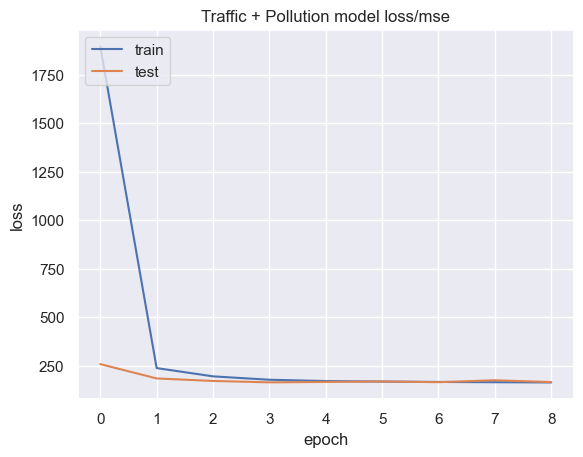

140/140 - 3s - 19ms/step - loss: 180.6252 - mse: 180.6252

MSE: 180.62522888183594


In [32]:
def summarize_history_loss(history, title):
    # summarize history for Loss/MSE
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

summarize_history_loss(history, "Traffic + Pollution model loss/mse")

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


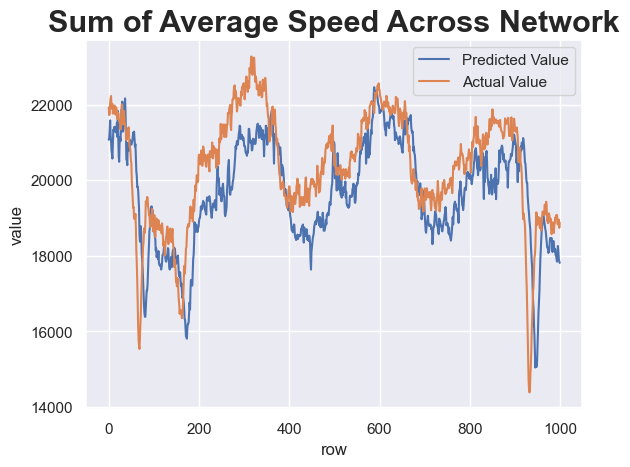

In [38]:
def plot_prediction_across_network(model, val_arrays, val_labs, title):
    y_pred_test = model.predict(val_arrays)
    y_true_test = val_labs

    # aggregating for easier visualization
    y_pred_dv = [row.sum() for row in y_pred_test]
    y_true_dv = [row.sum() for row in y_true_test]

    start = 1000
    ts = 1000

    plt.plot(y_pred_dv[start:start+ts], label='Predicted Value')
    plt.plot(y_true_dv[start:start+ts], label='Actual Value')
    plt.title(title,
            fontsize=22, fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend()
    plt.show()

plot_prediction_across_network(model, val_arrays, val_labs, 'Sum of Average Speed Across Network')

In [39]:
pred_cols = [f"{col}_pred" for col in traffic_df.columns]

y_pred_test = pd.DataFrame(model.predict(val_arrays), columns=pred_cols)
y_pred_test.head()

140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


,610_pred,611_pred,612_pred,613_pred,614_pred,615_pred,616_pred,617_pred,618_pred,619_pred,...,1049_pred,1050_pred,1051_pred,1052_pred,1053_pred,1054_pred,1055_pred,1056_pred,1057_pred,1058_pred
0,4.891193,1.507195,7.347497,5.860577,8.796427,8.387159,8.682600,9.034568,4.582588,5.955216,...,3.025174,2.945880,3.827316,6.638339,4.232975,9.518989,8.261565,9.601380,10.087266,7.633844
1,13.386798,3.749848,12.273046,9.178619,12.658777,13.275443,18.530743,18.232683,10.596193,9.966481,...,6.845966,8.130885,6.089883,10.809589,9.407589,18.798269,15.653785,17.872705,18.709751,17.517443
2,17.434790,5.747874,17.297028,10.421517,13.216615,18.473150,18.750582,23.596994,10.676128,13.293954,...,9.459298,9.223813,9.076786,13.060152,12.221617,22.376328,21.044024,24.152971,22.725445,23.733160
3,14.588398,5.652943,15.224874,9.003463,13.884033,16.795296,18.311939,21.896215,9.828892,13.697741,...,9.517501,7.601196,9.461764,10.776101,10.684497,20.805471,19.997334,22.633709,19.696245,22.454411
4,22.824495,3.946465,19.127190,17.205355,21.812130,22.267359,33.295921,23.916960,21.188269,11.518949,...,11.492578,15.493761,5.407031,22.148447,8.719907,29.709835,21.025974,18.838972,34.331768,20.461840


In [40]:
y_pred_test.shape

(4453, 449)

# Additional Code to Create Data Visualization Dataset

In [41]:
y_pred_test_sample = y_pred_test[-4000:]

dv_data = combined_pollution_traffic.iloc[-y_pred_test_sample.shape[0]:]
dv_data.iloc[-1000:] = np.nan

y_pred_test_sample.index = dv_data.index
y_pred_test_sample.iloc[:y_pred_test_sample.shape[0]-1000] = np.nan

dv_data = dv_data.merge(y_pred_test_sample,
                        how="left",
                        left_index=True,
                        right_index=True)

all_sensors = [dv_data.iloc[_, :449].sum()for _ in range(dv_data.shape[0])]
all_sensors = [np.nan if i == 0 else i for i in all_sensors ]
dv_data["all_sensors"] = all_sensors

all_sensors_pred = [dv_data.iloc[_, input_features:(
    input_features+output_features)].sum() for _ in range(dv_data.shape[0])]
all_sensors_pred = [np.nan if i == 0 else i for i in all_sensors_pred ]
dv_data["all_sensors_pred"] = all_sensors_pred

dv_data["timestamp"] = dv_data.index

dv_data = pd.melt(dv_data, id_vars="timestamp")
dv_data.set_index("timestamp", drop=True, inplace=True)

dv_data["filter_label"] = [val[0:4] for val in dv_data["variable"]]
dv_data["filter_label"] = [val[0:3] if val[-1]=="_" else val for val in dv_data["filter_label"]]

/var/folders/29/b1zgt_4148qbjk0pt48_ybym0000gn/T/ipykernel_66171/314214263.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred_test_sample.iloc[:y_pred_test_sample.shape[0]-1000] = np.nan


In [42]:
dv_data[dv_data["variable"].isin(['particullate_matter', 'carbon_monoxide', 'sulfure_dioxide',
                                 'nitrogen_dioxide']) == False].to_csv("aai-530-final-project-traffic-pollution.csv")

In [43]:
dv_data[dv_data["variable"].isin(
    ['particullate_matter', 'carbon_monoxide', 'sulfure_dioxide', 'nitrogen_dioxide'])].to_csv("pollution_ts.csv")